In [1]:
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
from skimage import measure

from scipy.ndimage import center_of_mass
from glob import glob
import random

/tmp/ipykernel_1602401/2330360485.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


Labels from the mask: [0 1 2 3 4 5 6]
Reviewing small cell sizes (less than 100 pixels):

Number of cells after applying size threshold: 6
Average cell size: 32023.333333333332 pixels
Minimum cell size: 21967.0 pixels (Label: 1)
Maximum cell size: 41977.0 pixels (Label: 3)
Background size: 9275764 pixels(Label: 0)

Individual cell areas after filtering:
Cell label: 1, Cell area: 21967.0 pixels
Cell label: 2, Cell area: 26337.0 pixels
Cell label: 3, Cell area: 41977.0 pixels
Cell label: 4, Cell area: 30013.0 pixels
Cell label: 5, Cell area: 35508.0 pixels
Cell label: 6, Cell area: 36338.0 pixels
Labels in plot_labels function: [0 1 2 3 4 5 6]


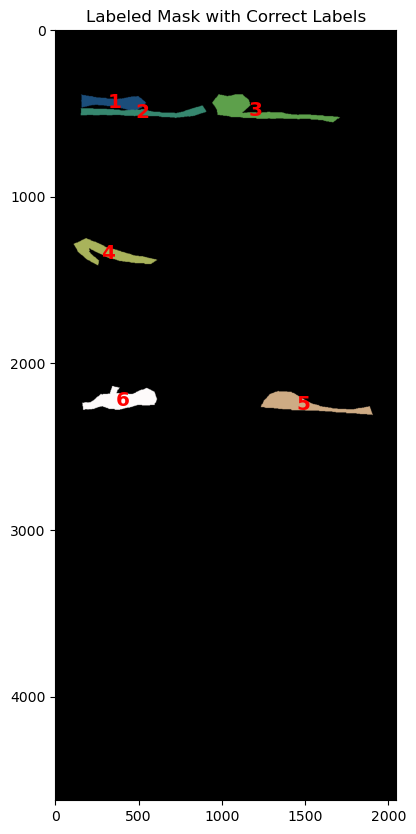

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import imageio
# from skimage import measure


def analyze_mask(frame, mask_path_template, size_threshold=100):


    def make_np(img):
        return np.array(img)


    def plot_labels(original, ax, title=None,
                    txt_args={'color':'red', 'ha':'center', 'va':'center', 
                              'fontsize':'x-large', 'fontweight':'bold'},
                    cmap='gist_earth'):
        ax.imshow(original, cmap=cmap)
        labels = np.unique(original)
        print("Labels in plot_labels function:", labels)
        ax.set_title(title)
        for label in labels:
            if label != 0:  # Skip background label
                inds = np.argwhere(original == label)
                loc = inds.mean(0)
                ax.text(loc[1], loc[0], str(label), **txt_args)

    
    # Load the mask image using imageio
    mask_path = mask_path_template.format(frame=frame)
    mask = imageio.imread(mask_path)

    # Print the labels directly from the mask
    unique_labels = np.unique(mask)
    print("Labels from the mask:", unique_labels)

    # Measure the properties of the labeled regions
    properties = measure.regionprops(mask)

    # Extract areas and labels, review small cell sizes
    labeled_areas = [(prop.label, prop.area) for prop in properties if prop.label != 0]
    labels, areas = zip(*labeled_areas)

    # Print details of very small cells
    print("Reviewing small cell sizes (less than 100 pixels):")
    for label, area in zip(labels, areas):
        if area < 100:
            print(f"Cell label: {label}, Cell size: {area} pixels")

    # Apply a size threshold to filter out small artifacts
    filtered_areas = [(prop.label, prop.area) for prop in properties if prop.label != 0 and prop.area >= size_threshold]
    filtered_labels, filtered_areas = zip(*filtered_areas)

    # Calculate the area of the background
    background_area = np.sum(mask == 0)

    # Compute the average, min, and max cell sizes for filtered cells
    average_cell_size_filtered = np.mean(filtered_areas)
    min_cell_size_filtered = np.min(filtered_areas)
    max_cell_size_filtered = np.max(filtered_areas)
    min_cell_label_filtered = filtered_labels[np.argmin(filtered_areas)]
    max_cell_label_filtered = filtered_labels[np.argmax(filtered_areas)]

    # Display filtered results and areas of individual cells
    print(f"\nNumber of cells after applying size threshold: {len(filtered_areas)}")
    print(f"Average cell size: {average_cell_size_filtered} pixels")
    print(f"Minimum cell size: {min_cell_size_filtered} pixels (Label: {min_cell_label_filtered})")
    print(f"Maximum cell size: {max_cell_size_filtered} pixels (Label: {max_cell_label_filtered})")
    print(f"Background size: {background_area} pixels(Label: 0)")
    # print(f"Background label: 0")

    # Print areas of individual cells
    print("\nIndividual cell areas after filtering:")
    for label, area in zip(filtered_labels, filtered_areas):
        print(f"Cell label: {label}, Cell area: {area} pixels")

    # Plot the labels for filtered cells, excluding the background label
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_labels(mask, ax, title="Labeled Mask with Correct Labels")
    plt.show()

# Example usage
frame = 41
# mask_path_template = "/home/MinaHossain/Label_5004/6row_images_min_A/01_ST/SEG/man_seg{frame:04d}.tif"
mask_path_template="/home/MinaHossain/EmbedTrack/ctc_raw_data/train/Cell-Data-P2/01_ST/SEG/man_seg{frame:04d}.tif"
# mask_path_template = "/home/MinaHossain/Label_5004/6row_images_min_A/02_GT/SEG/man_seg{frame:04d}.tif"
analyze_mask(frame, mask_path_template)



In [ ]:
# import os
# import numpy as np
# import tifffile
# import cv2
# import imageio
# import matplotlib.pyplot as plt
# from skimage import measure
# from scipy.ndimage import center_of_mass
# from glob import glob
# import random

# # === PARAMETERS ===
# image_dir = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"  # <<< CHANGE THIS
# output_dir = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video"  # <<< OUTPUT FOLDER
# target_cell_id = 4
# output_video = os.path.join(output_dir, f"cell_{target_cell_id}_only_video.avi")
# output_frame_list_file = os.path.join(output_dir, f"cell_{target_cell_id}_accurate_frame_list.txt")
# video_fps = 1
# upscale_factor = 2

# # === Ensure output directory exists ===
# os.makedirs(output_dir, exist_ok=True)

# # === ANALYZE MASK FUNCTION (Simplified and Clean) ===
# def analyze_mask_from_path(mask_path, frame):
#     def plot_labels(original, ax, title=None,
#                     txt_args={'color': 'red', 'ha': 'center', 'va': 'center',
#                               'fontsize': 'x-large', 'fontweight': 'bold'},
#                     cmap='gist_earth'):
#         ax.imshow(original, cmap=cmap)
#         labels = np.unique(original)
#         print("Labels in plot_labels function:", labels)
#         ax.set_title(title)
#         for label in labels:
#             if label != 0:
#                 inds = np.argwhere(original == label)
#                 loc = inds.mean(0)
#                 ax.text(loc[1], loc[0], str(label), **txt_args)

#     try:
#         mask = imageio.imread(mask_path)
#         unique_labels = np.unique(mask)
#         print(f"Frame {frame} - Labels from the mask: {unique_labels}")
#         fig, ax = plt.subplots(figsize=(10, 10))
#         plot_labels(mask, ax, title=f"Labeled Mask (Frame {frame})")
#         # plt.show()
#     except Exception as e:
#         print(f"❌ Failed to analyze mask for frame {frame}: {e}")

# # === MAIN PROCESSING ===
# mask_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
# cell_locations = {}
# target_frames = []
# all_cell_ids = set()

# # Collect all cell IDs and their centroid locations
# for path in mask_paths:
#     image_name = os.path.basename(path)
#     mask = tifffile.imread(path)

#     print(f"Checking {image_name} - Labels: {np.unique(mask)}")  # Diagnostic Print

#     cell_ids = np.unique(mask)
#     cell_ids = cell_ids[cell_ids != 0]
#     all_cell_ids.update(cell_ids)

#     cell_locations[image_name] = {}
#     for cid in cell_ids:
#         binary_mask = (mask == cid)
#         if np.any(binary_mask):
#             y, x = center_of_mass(binary_mask)
#             cell_locations[image_name][cid] = (x, y)

# # Assign distinct color to each cell
# cell_colors = {cid: (0, 0, 255) if cid == target_cell_id else tuple(random.randint(50, 230) for _ in range(3)) for cid in all_cell_ids}

# frames = []

# # Process only frames where target cell is present using cell_locations
# for frame_idx, path in enumerate(mask_paths, start=1):
#     image_name = os.path.basename(path)
#     mask = tifffile.imread(path)

#     # Use robust check
#     if target_cell_id not in cell_locations[image_name]:
#         print(f"Target cell ID {target_cell_id} NOT FOUND in {image_name}")  # Diagnostic
#         continue

#     print(f"✅ Target cell ID {target_cell_id} FOUND in {image_name}")  # Diagnostic
#     target_frames.append((frame_idx, image_name))
#     h, w = mask.shape
#     color_frame = np.zeros((h, w, 3), dtype=np.uint8)

#     for cid in np.unique(mask):
#         if cid == 0:
#             continue
#         region = (mask == cid)
#         color_frame[region] = cell_colors[cid]

#     for cid, (x, y) in cell_locations.get(image_name, {}).items():
#         label_size = 1.6 if cid == target_cell_id else 0.9
#         label_thickness = 3 if cid == target_cell_id else 2
#         label_color = cell_colors[cid]

#         if cid == target_cell_id:
#             cv2.circle(color_frame, (int(x), int(y)), 10, (255, 255, 255), -1)
#         cv2.putText(color_frame, f"{cid}", (int(x)+10, int(y)-10),
#                     cv2.FONT_HERSHEY_SIMPLEX, label_size, label_color, label_thickness)

#     cv2.putText(color_frame, f"Frame {frame_idx:03d}", (20, 50),
#                 cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), 4)
#     cv2.putText(color_frame, image_name, (20, 100),
#                 cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255, 255, 255), 3)
#     cv2.putText(color_frame, f"Target Cell ID {target_cell_id} Visible", (20, 150),
#                 cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 255, 255), 3)

#     # Run analysis/plotting function
#     analyze_mask_from_path(mask_path=path, frame=frame_idx)

#     # Upscale
#     color_frame = cv2.resize(color_frame,
#                              (int(w * upscale_factor), int(h * upscale_factor)),
#                              interpolation=cv2.INTER_NEAREST)
#     frames.append(color_frame)

# # Save video
# if frames:
#     height, width, _ = frames[0].shape
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(output_video, fourcc, video_fps, (width, height))
#     for frame in frames:
#         out.write(frame)
#     out.release()
#     print(f"✅ Final video saved: {output_video}")
# else:
#     print("❌ No frames found for target cell.")

# # Save frame list
# with open(output_frame_list_file, "w") as f:
#     for frame_idx, image_name in target_frames:
#         f.write(f"Frame {frame_idx:03d} - {image_name}\n")

# print(f"✅ Accurate frame list saved: {output_frame_list_file}")
# print(f"✅ Total frames with target cell: {len(target_frames)}")


# Modify your tracking code to also store original mask label alongside assigned tracking ID in CSV?
# OR update your video generation code to use the CSV directly?


In [18]:
# def analyze_mask_from_path(mask_path, frame):
#     def plot_labels(original, ax, title=None,
#                     txt_args={'color': 'red', 'ha': 'center', 'va': 'center',
#                               'fontsize': 'x-large', 'fontweight': 'bold'},
#                     cmap='gist_earth'):
#         ax.imshow(original, cmap=cmap)
#         labels = np.unique(original)
#         print("Labels in plot_labels function:", labels)
#         ax.set_title(title)
#         for label in labels:
#             if label != 0:
#                 inds = np.argwhere(original == label)
#                 loc = inds.mean(0)
#                 ax.text(loc[1], loc[0], str(label), **txt_args)

#     try:
#         mask = imageio.imread(mask_path)
#         unique_labels = np.unique(mask)
#         print(f"Frame {frame} - Labels from the mask: {unique_labels}")
#         fig, ax = plt.subplots(figsize=(10, 10))
#         plot_labels(mask, ax, title=f"Labeled Mask (Frame {frame})")
#         # plt.show()
#     except Exception as e:
#         print(f"❌ Failed to analyze mask for frame {frame}: {e}")

# Final Cell's frame list and Video

In [ ]:
# Re-execute the final code after environment reset


import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import imageio
from skimage.measure import regionprops, label
from scipy.spatial import distance
import re

# === PARAMETERS ===
csv_path = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/Cells_Centroid_Velocity_MA_5.csv"  # <<< Adjust if needed
image_dir = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"  # Directory containing raw mask images
output_dir = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video"


temp_plot_dir = os.path.join(output_dir, "temp_plots")
target_cell_id = 12
output_video = os.path.join(output_dir, f"Cell_{target_cell_id}_Matched_Mask_Label_Video_{target_cell_id}.avi")
output_frame_list = os.path.join(output_dir, f"Cell_{target_cell_id}_Matched_Frame_List_{target_cell_id}.txt")
video_fps = 1
distance_threshold = 50

# === Ensure directories exist ===
os.makedirs(output_dir, exist_ok=True)
os.makedirs(temp_plot_dir, exist_ok=True)

# === Load CSV data ===
df = pd.read_csv(csv_path)
df_target = df[df["Cell Number"] == target_cell_id]
target_frames = sorted(df_target["Frame"].unique())

# === Map mask files using regex to extract actual frame numbers
mask_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
mask_map = {}
for path in mask_paths:
    fname = os.path.basename(path)
    frame_match = re.search(r'(\d{2,4})', fname)
    if frame_match:
        frame_num = int(frame_match.group(1))
        mask_map[frame_num] = path

# === Define plotting function with frame number and matched cell highlight
def plot_matched_labels(mask, ax, frame_num, matched_label=None,
                        txt_args={'color': 'cyan', 'ha': 'center', 'va': 'center',
                                  'fontsize': 'large', 'fontweight': 'bold'},
                        highlight_args={'color': 'red', 'ha': 'center', 'va': 'center',
                                        'fontsize': 'xx-large', 'fontweight': 'bold'},
                        cmap='gist_earth'):
    ax.imshow(mask, cmap=cmap)
    labels = np.unique(mask)
    ax.set_title(f"Cell {target_cell_id} Matched in Mask")
    for label_id in labels:
        if label_id == 0:
            continue
        coords = np.argwhere(mask == label_id)
        centroid = coords.mean(axis=0)
        label_txt_args = highlight_args if label_id == matched_label else txt_args
        ax.text(centroid[1], centroid[0], str(label_id), **label_txt_args)
    # Add frame number visibly in the corner
    ax.text(30, 30, f"Frame {frame_num}", fontsize=24, color='white',
            fontweight='bold', bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.4'))
    ax.axis("off")

# === Process frames
plot_frame_paths = []
matched_frame_ids = []

for frame_num in target_frames:
    if frame_num not in mask_map:
        print(f"❌ Frame {frame_num} not found in mask map.")
        continue

    mask_img = imageio.imread(mask_map[frame_num])
    labeled_mask = label(mask_img)
    regions = regionprops(labeled_mask)

    row = df_target[df_target["Frame"] == frame_num]
    if row.empty:
        continue
    cx_csv = row["Centroid_X_MA"].values[0]
    cy_csv = row["Centroid_Y_MA"].values[0]

    min_dist = float("inf")
    matched_label = None
    for region in regions:
        y, x = region.centroid
        dist = distance.euclidean((cx_csv, cy_csv), (x * 0.68, y * 0.68))
        if dist < min_dist and dist <= distance_threshold:
            min_dist = dist
            matched_label = region.label

    if matched_label is None:
        print(f"⚠️ Cell 4 NOT matched in frame {frame_num}")
        continue

    matched_frame_ids.append(frame_num)

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_matched_labels(labeled_mask, ax, frame_num, matched_label=matched_label)
    plot_path = os.path.join(temp_plot_dir, f"frame_{frame_num:03d}.png")
    fig.savefig(plot_path, bbox_inches="tight")
    plt.close(fig)
    plot_frame_paths.append(plot_path)

# === Assemble final video
if plot_frame_paths:
    sample_img = cv2.imread(plot_frame_paths[0])
    height, width, _ = sample_img.shape
    print(f"Video frame size: {width}x{height}")
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_video, fourcc, video_fps, (width, height))
    for img_path in plot_frame_paths:
        img = cv2.imread(img_path)
        out.write(img)
    out.release()
    print(f"✅ Final hybrid-labeled video with frame number and Cell 4 matched saved: {output_video}")
else:
    print("❌ No frames drawn. Video not created.")

# === Save matched frame list
with open(output_frame_list, "w") as f:
    for frame_num in matched_frame_ids:
        f.write(f"{frame_num}\n")

print(f"✅ Matched frame list saved to: {output_frame_list}")
print(f"✅ Total frames with matched Cell_Id-{target_cell_id}: {len(matched_frame_ids)}")


/tmp/ipykernel_1602401/362822789.py:78: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_img = imageio.imread(mask_map[frame_num])


Video frame size: 292x657
✅ Final hybrid-labeled video with frame number and Cell 4 matched saved: /home/MinaHossain/EmbedTrack/Cell_Frame-Video/Cell_12_Matched_Mask_Label_Video_12.avi
✅ Matched frame list saved to: /home/MinaHossain/EmbedTrack/Cell_Frame-Video/Cell_12_Matched_Frame_List_12.txt
✅ Total frames with matched Cell-12: 59


# New Analysis

In [17]:
# Re-import dependencies after code execution environment reset
# can Modify your tracking code to also store original mask label alongside assigned tracking ID in CSV?
import os
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
import time
import re
import matplotlib.pyplot as plt

# === PARAMETERS ===

# csv_path = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/Cells_Centroid_Velocity_MA_5.csv"  # <<< Adjust if needed
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"  # Directory containing raw mask images
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video"
size_threshold = 1000
max_centroid_dist = 20
window_size = 5

# === Ensure output directory exists ===
os.makedirs(output_directory, exist_ok=True)

start_time = time.time()

def calculate_shape_factors(region):
    area = region.area
    perimeter = region.perimeter
    convex_area = region.convex_area
    bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])
    solidity = area / convex_area if convex_area > 0 else 0
    extent = area / bounding_box_area if bounding_box_area > 0 else 0
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

    convex_mask = region.convex_image.astype(np.uint8) * 255
    contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
    convexity = convex_perimeter / perimeter if perimeter > 0 else 0

    min_diameter = region.minor_axis_length
    max_diameter = region.major_axis_length
    elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
    compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

    centroid = region.centroid
    cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Scaled

    return [area, perimeter, extent, solidity, compactness, elongation,
            circularity, convexity, cx, cy]

# === Load masks ===
mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
if not mask_files:
    raise FileNotFoundError(f"No TIFF files found in {mask_directory}")

all_results = []
cell_tracks = {}
previous_centroids = {}
previous_frames = {}

current_cell_id = 1

for mask_path in mask_files:
    frame_str = os.path.splitext(os.path.basename(mask_path))[0]
    frame_match = re.search(r'\d+', frame_str)
    frame = int(frame_match.group()) if frame_match else None
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    if mask is None:
        print(f"Skipping {frame}: Could not read {mask_path}.")
        continue

    labeled_mask = label(mask)
    properties = regionprops(labeled_mask)
    filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

    if not filtered_regions:
        print(f"Skipping frame {frame}: No valid cells detected.")
        continue

    used_cell_ids = set()
    for region in filtered_regions:
        shape_factors = calculate_shape_factors(region)
        centroid = (shape_factors[-2], shape_factors[-1])
        matched_cell_id = None

        # Get original label from the mask
        original_label = np.unique(mask[region.coords[:, 0], region.coords[:, 1]])[0]

        for cell_id, prev_centroid in cell_tracks.items():
            if cell_id not in used_cell_ids:
                x_dist = centroid[0] - prev_centroid[0]
                y_dist = centroid[1] - prev_centroid[1]
                if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

        if matched_cell_id is None:
            matched_cell_id = current_cell_id
            used_cell_ids.add(matched_cell_id)
            current_cell_id += 1

        prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
        prev_frame = previous_frames.get(matched_cell_id, None)
        if prev_x is not None and prev_y is not None and prev_frame is not None:
            frame_diff = frame - prev_frame
            x_centroid_distance = centroid[0] - prev_x
            y_centroid_distance = centroid[1] - prev_y
            x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
            y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
        else:
            x_centroid_distance = y_centroid_distance = 0
            x_centroid_velocity = y_centroid_velocity = 0

        previous_centroids[matched_cell_id] = centroid
        previous_frames[matched_cell_id] = frame
        cell_tracks[matched_cell_id] = centroid

        all_results.append([
            matched_cell_id,
            original_label,
            frame,
            *shape_factors,
            x_centroid_distance,
            y_centroid_distance,
            x_centroid_velocity,
            y_centroid_velocity
        ])

columns = ["Cell Number", "Original Mask Label", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
           "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y",
           "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"]

df = pd.DataFrame(all_results, columns=columns)

# Save CSV with Original Label Included
csv_path = os.path.join(output_directory, f"Cells_Centroid_With_OriginalLabel.csv")
df.to_csv(csv_path, index=False)

print(f"✅ CSV with original mask labels saved to: {csv_path}")
print(f"✅ Total Cells Tracked: {df['Cell Number'].nunique()}")
print(f"✅ Total Frames Processed: {df['Frame'].nunique()}")
print(f"✅ Execution Time: {time.time() - start_time:.2f} seconds")


✅ CSV with original mask labels saved to: /home/MinaHossain/EmbedTrack/Cell_Frame-Video/Cells_Centroid_With_OriginalLabel.csv
✅ Total Cells Tracked: 103
✅ Total Frames Processed: 100
✅ Execution Time: 23.06 seconds
